### Statement of the problem:

CoverMyMeds Challenge Problem
>At CoverMyMeds, time series analysis forms the backbone of the financial projections we make at the beginning of each fiscal year and helps us set realistic but challenging company goals.  Many of our products have multiple customers whose behaviors might (or might not) influence each other.  We are presenting daily volume (can be thought of as purchases) of one product for three customers. Questions that you should answer in this project are the following: 
>* What trends are in the data at the daily, monthly, and yearly levels?
>* What variables do and do not affect daily volume?
>* How does the behavior of one customer affect the behavior of the other customers?
>* How accurately can you predict what will happen in 2019 at the monthly and yearly levels?
>* How accurate are your projections 1 month, 3 months, and 6 months after the  day they were forecasted from?

### Exploratory analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
np.random.seed(1)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [ ]:
# needs to install pyarrow
df = pd.read_parquet('data/cmm_erdos_bootcamp_2020_timeseries.pq', engine='auto')
df.shape

Very small data size

In [ ]:
df.head()

Check if there's missing value

In [ ]:
df.isna().sum()

In [ ]:
df[['volume_A','volume_B', 'volume_C']].describe()

Convert 1sf column to datetime type

In [ ]:
df['date_val'] = pd.to_datetime(df['date_val'], yearfirst=True)
df.set_index(['date_val'], inplace = True)

In [ ]:
dayly_effect = df.groupby('day_of_week')[['volume_A', 'volume_B', 'volume_C']].sum()

In [ ]:
plt.plot(dayly_effect)
plt.show()

In [ ]:
weekday_effect

In [ ]:
weekday_effect = df.groupby('is_weekday')[['volume_A', 'volume_B', 'volume_C']].sum()
weekday_effect

In [ ]:
df.groupby('is_holiday')[['volume_A', 'volume_B', 'volume_C']].sum()

In [ ]:
df[['volume_A','volume_B', 'volume_C']].describe()

In [ ]:
df_new = df.drop(columns = ['calendar_year', 'calendar_month', 'calendar_day'])

Inspect correlation

In [ ]:
df_new.corr()

In [ ]:
# scatter matrix makes a matrix of scatter plots
from pandas.plotting import scatter_matrix

scatter_matrix(df_new, figsize = (14,14), alpha = 1)

plt.show()

In [ ]:
df_new['volume_C'].plot(figsize=(10, 5))
plt.show()

In [ ]:
test_a = df_new['volume_A'].to_numpy()

### ARIMA

In [321]:
df = pd.read_parquet('data/cmm_erdos_bootcamp_2020_timeseries.pq', engine='auto')
df['date'] = pd.to_datetime(df['date_val'], yearfirst=True)
df.set_index(['date'], inplace = True)
df_new = df.drop(columns = ['date_val','calendar_year', 'calendar_month', 'calendar_day', 'day_of_week'])
df_new = df_new.rename(columns={'volume_A': 'vol_A', 'volume_B': 'vol_B', 'volume_C': 'vol_C'})
df_new = df_new.asfreq(freq='D')

In [406]:
from models.models import Data_Pipe, ARIMA_model

para_model = {'window': 183, 'scale': False, 'smooth': False, 'scale_type': 'max_min', 
              'target': 'vol_C', 'external': 'vol_B', 
              'dtype': None, 'p': 7, 'q': 0, 'd': 0}
#para_model.update({'dtype': 'log_diff'})
model = ARIMA_model(df_new, **para_model)

In [407]:
model.build_model()
model.fit_model()

/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [394]:
model.stationary_test()

the time series log_diff_vol_C is stationary!


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


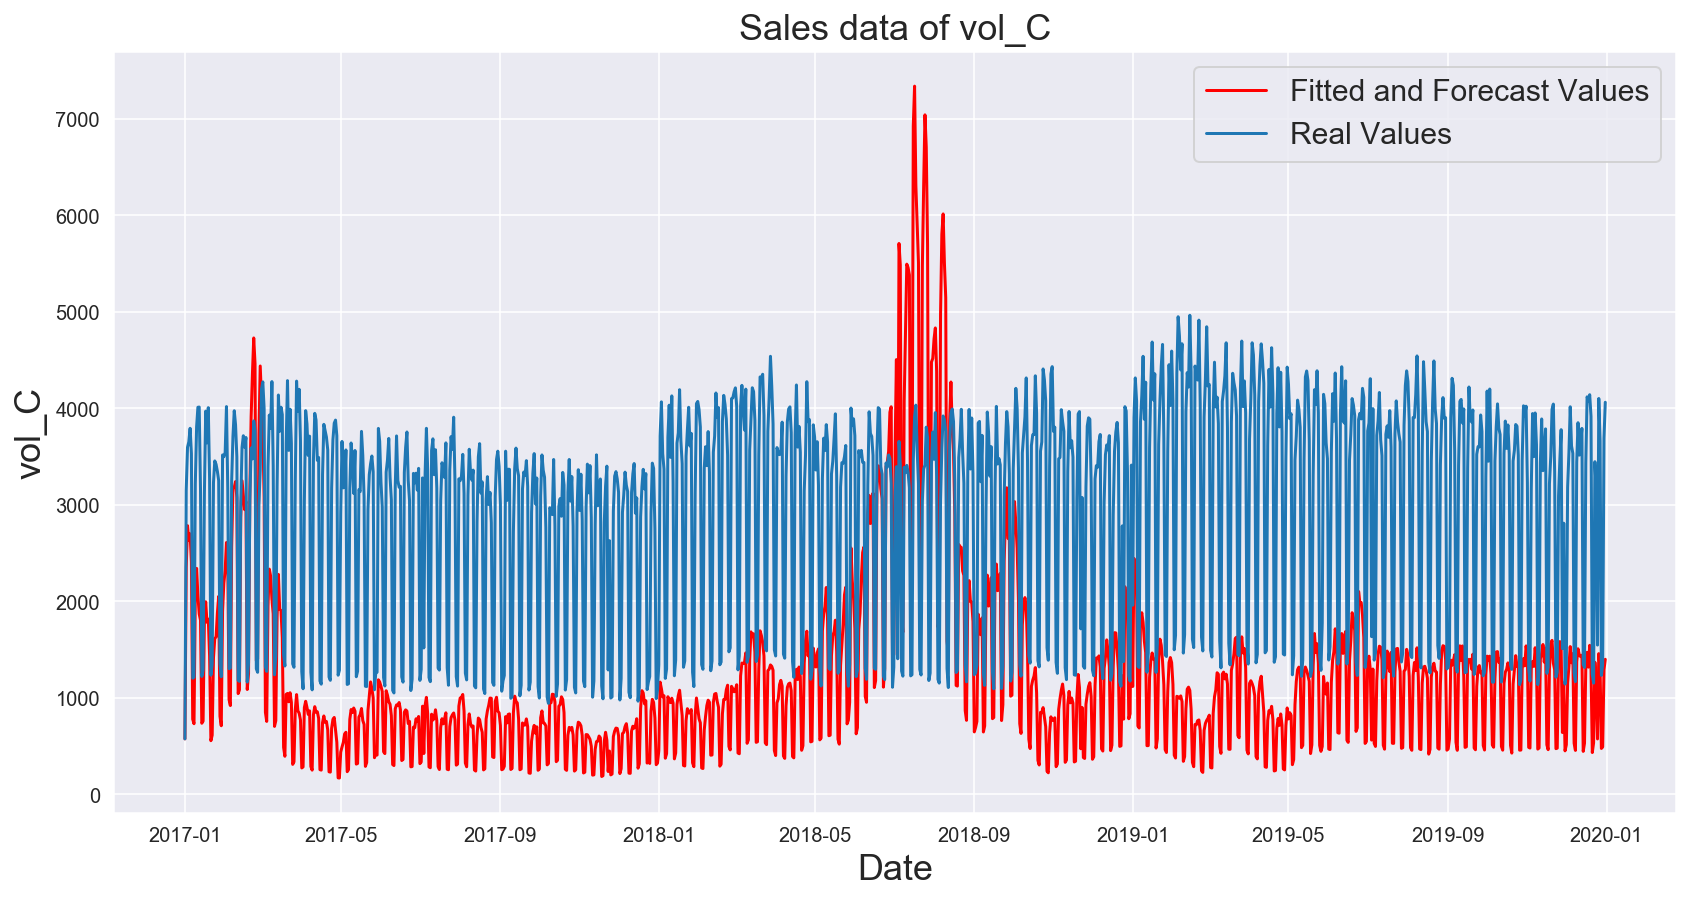

In [408]:
model.plot_data()

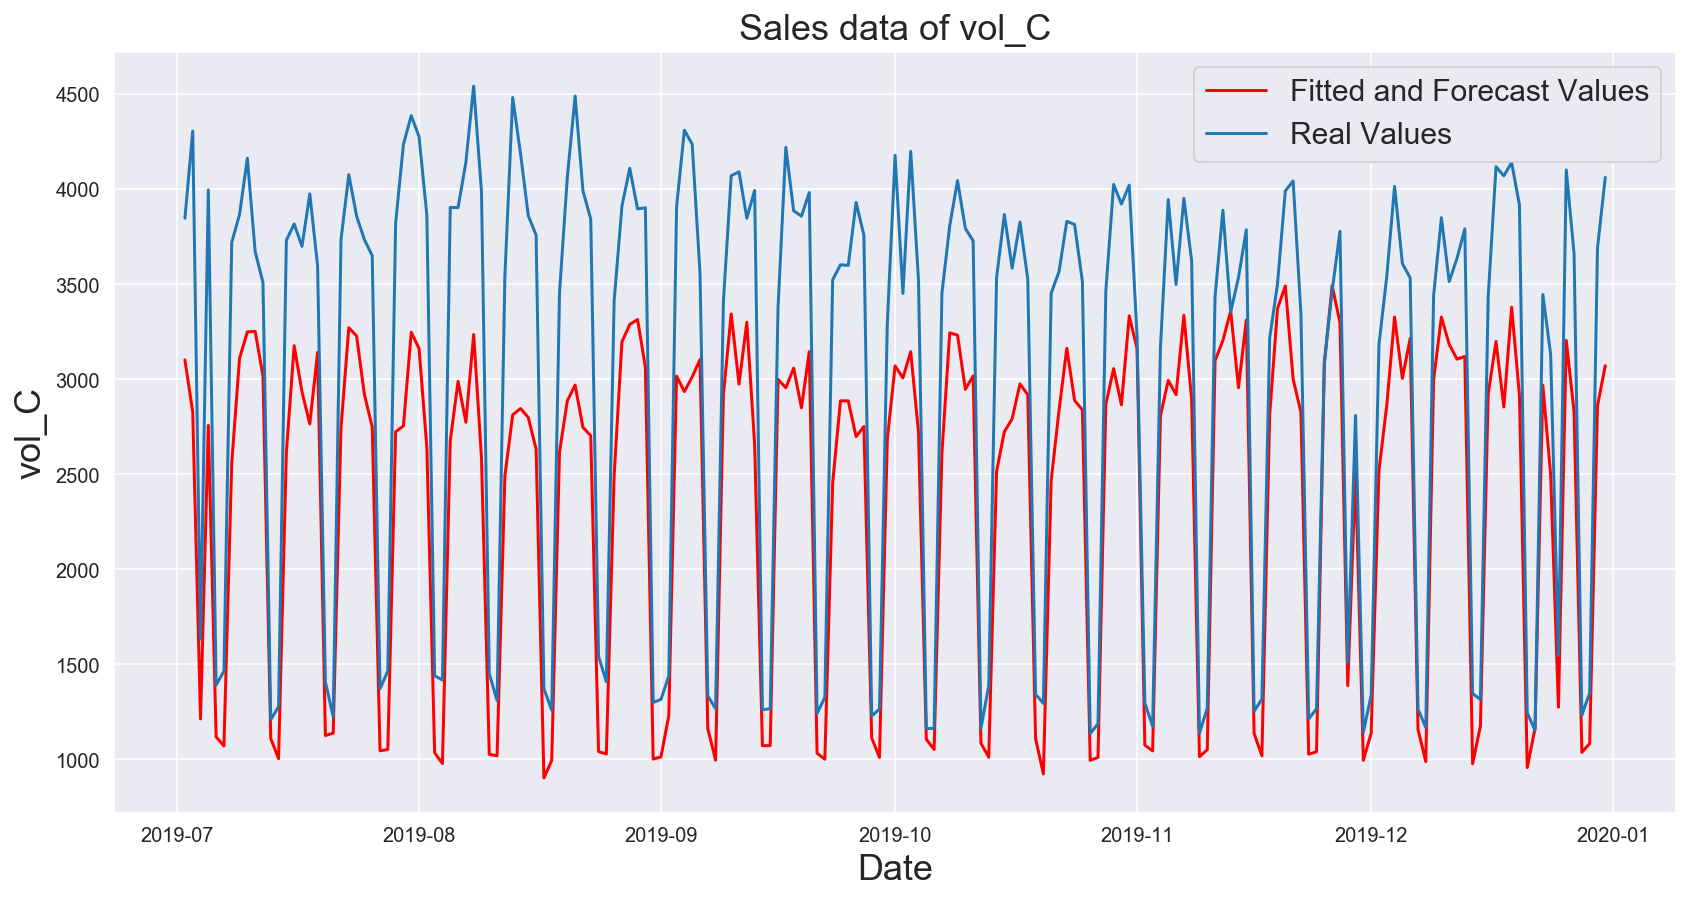

In [402]:
model.plot_data(plot_all = False)

In [403]:
model.error_rate[-len(model.test):].mean()

20.332150900450905

Quick bookkeeping: `external: is_workday`, `dtype=None`, `q=7`, `p=7 or 0`, `d=0`, `smooth=False` seems work good for the generic model.

There is a strong correlation between B and C sales. When fitting B or C, setting `external = vol_C/B` seems work best.

### Detect outliers

In [331]:
def plot_weekday(col = 'vol_A'):
    plt.figure(figsize=(10,7))
    plt.plot(df_new.index, df_new[col], label="A" ,alpha=0.4)
    plt.scatter(df_new.index[(df_new['is_weekday']==True)], df_new[col][(df_new['is_weekday']==True)], label='weekday A', alpha=0.8)
    plt.scatter(df_new.index[(df_new['is_weekday']==False)], df_new[col][(df_new['is_weekday']==False)], label='no weekday A', alpha=0.8)
    plt.scatter(df_new.index[df_new['is_holiday']==True], df_new[col][df_new['is_holiday']==True], label='Holiday', alpha=0.8)

    plt.xlabel("Date", fontsize=18)
    plt.ylabel("Volume", fontsize=18)

    plt.legend()
    plt.show()

In [340]:
def plot_workday(col = 'vol_A'):
    plt.figure(figsize=(10,7))
    plt.plot(df_new.index, df_new[col], label="A" ,alpha=0.4)
    plt.scatter(df_new.index[(df_new['is_workday']==True)], df_new[col][(df_new['is_workday']==True)], label='work day A', alpha=0.8)
    plt.scatter(df_new.index[(df_new['is_workday']==False)], df_new[col][(df_new['is_workday']==False)], label='no workday A', alpha=0.8)
    plt.scatter(df_new.index[df_new['is_holiday']==True], df_new[col][df_new['is_holiday']==True], label='Holiday', alpha=0.8)
    plt.xlabel("Date", fontsize=18)
    plt.ylabel("Volume", fontsize=18)

    plt.legend()
    plt.show()

If we look at the data distinguished by `is_workday`, it looks like there are several outliers in the no workday sales:

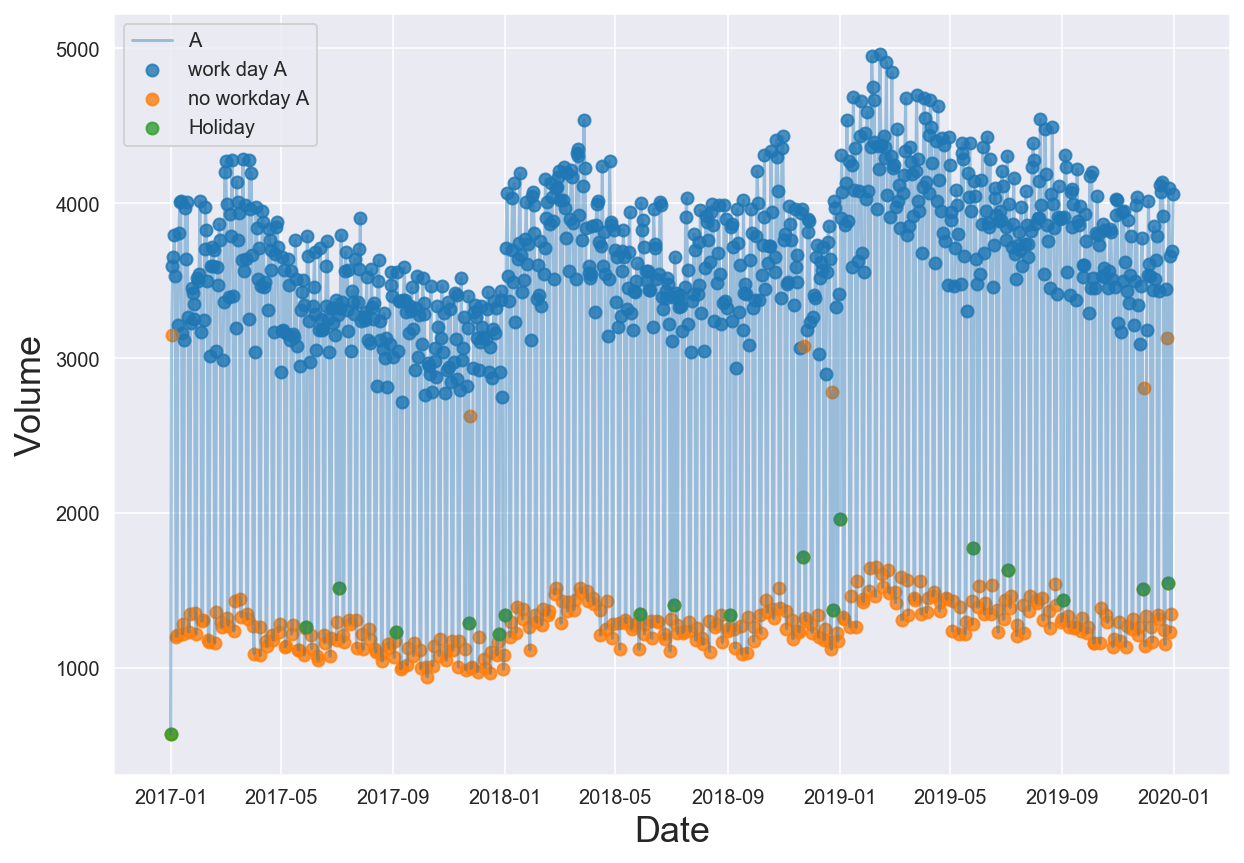

In [341]:
plot_workday(col='vol_C')

But if we look at `is_weekday` instead, those outliers just disappear. So we should not worry about outliers if we only consider `is_weekday` feature. 

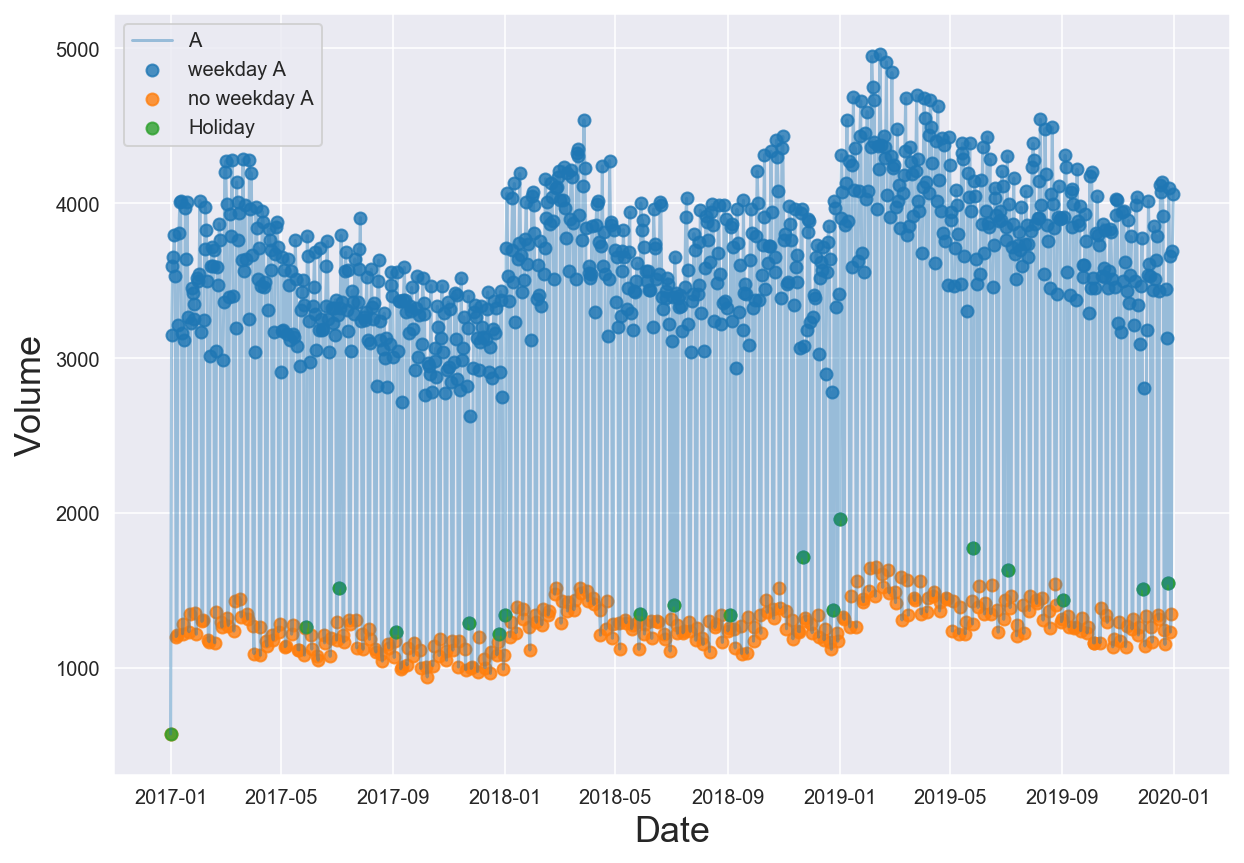

In [342]:
plot_weekday(col='vol_C')

We can use the following code to confirm the observation:

In [362]:
col = 'vol_C'
non_work = df_new[col][(df_new['is_workday']==False)]
too_much = df_new.loc[(df_new[col] > (non_work.mean()+1.96*non_work.std())) & (df_new['is_workday'] == False)]

In [363]:
too_much

,is_weekday,is_workday,is_holiday,vol_A,vol_B,vol_C
date,,,,,,
2017-01-02,1,0,0,5073,2976,3149
2017-11-24,1,0,0,6057,2554,2628
2018-11-23,1,0,0,6890,3399,3076
2018-12-24,1,0,0,6153,3034,2781
2019-01-01,1,0,1,4194,1750,1959
2019-11-29,1,0,0,7183,3238,2809
2019-12-24,1,0,0,7181,3212,3130


On these 'anomalous' huge sale in those not-supposed-to-work days, they are all actually weekdays. The customers just don't take the time off.

Also the `is_holiday` seems don't have too much impact on the overal sale.

In [347]:
df_new[df_new['is_holiday']==True][['vol_A','vol_B','vol_C']].describe()

,vol_A,vol_B,vol_C
count,18.000000,18.000000,18.000000
mean,3213.111111,1522.500000,1415.500000
std,763.809792,283.607486,290.419828
min,974.000000,701.000000,574.000000
25%,2881.750000,1427.000000,1301.500000
50%,3169.000000,1568.000000,1389.500000
75%,3785.250000,1716.500000,1538.500000
max,4194.000000,1903.000000,1959.000000


Since most holidays are non weekdays, they don't differ much with the ordinary non weekday data.

In [354]:
df_new[(df_new['is_weekday']==False) & (df_new['is_holiday']==False)][['vol_A','vol_B','vol_C']].describe()

,vol_A,vol_B,vol_C
count,312.000000,312.000000,312.000000
mean,2657.262821,1337.410256,1268.641026
std,417.508197,132.330696,137.250115
min,1736.000000,1010.000000,942.000000
25%,2321.500000,1248.750000,1173.000000
50%,2729.500000,1339.500000,1265.000000
75%,2968.000000,1425.000000,1350.250000
max,3539.000000,1693.000000,1655.000000


### Exponential Smoothing

In [26]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

window = 365
train = df_new['vol_A'][:-window]
test = df_new['vol_A'][-window:]
mul_mod = ExponentialSmoothing(train, seasonal_periods=365, seasonal='mul')

In [27]:
result = mul_mod.fit()
forecast_values = result.forecast(len(test))

/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [47]:
(100*np.abs((test-forecast_values)/test)).mean()

52.25155781424058

### Seasonal-Trend Decomposition

In [36]:
from statsmodels.tsa.seasonal import STL

stl_model = STL(train, trend_deg = 1, seasonal_deg = 1)
stl_fit = stl_model.fit()

### Backtest for model selection

In [375]:
from models.backtest import Backtest_ARIMA

# copy parameters for building the ARIMA model
para_back_test = para_model
month = 30
extra_para = {'p_max': 7, 'q_max': 7, 'd_max': 2, 'method': 'expand', 'span': 12*month, 'slide': 2*month}
# update parameters for backtesting
para_back_test.update(extra_para)

In [366]:
backtest = Backtest_ARIMA(df_new, **para_back_test)

In [367]:
backtest.model_selection()

/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:714: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 0, 2,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInvers

Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 0, 2,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 0, 3,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 0, 4,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 0, 4,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 0, 4,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 0, 4,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:672: RuntimeWarning: invalid value encountered in arctanh
  invarcoefs = 2*np.arctanh(params)


Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 0, 4,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 0, 4,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:714: RuntimeWarning: divide by zero encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: invalid value encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 0, 5,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 0, 5,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 0, 5,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 0, 5,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 0, 5,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to

Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 0, 6,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 0, 6,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 0, 6,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 0, 6,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed,

Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 0, 7,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or 

Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 0, 7,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or 

Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 1, 3,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. 

Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 1, 4,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed,

Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 1, 5,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 1, 5,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to

Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 1, 5,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 1, 5,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 1, 6,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed,

Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 1, 6,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed,

Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 1, 7,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 1, 7,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 1, 7,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 1, 7,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 1, 7,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 1, 7,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed,

Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 1, 7,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 1, 7,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 0,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 0,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 0,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 0,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 0,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 0,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 0,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 0,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 0,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 0,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 1,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 1,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 1,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 1,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 1,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed,

Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 1,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 1,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 1,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 2,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 2,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 2,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or 

Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 2,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed,

Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 3,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 3,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 3,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 3,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 3,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 3,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 3,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 3,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 3,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 3,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 3,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 4,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 4,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 4,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 4,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 4,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 4,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 4,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 4,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 4,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 4,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 5,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 5,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 5,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 5,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 5,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 5,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 5,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 5,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed,

Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 7,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 7,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 7,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 7,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 7,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 7,
Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 7,


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to

Unable to fit with current parameters
Unstable model, skip these parameters:                                      7, 2, 7,
the best mse model is [7, 0, 4] !
the best aic model is [7, 2, 4] !


In [ ]:
7, 4, 0

7, 4, 2

In [ ]:
backtest.mse_scores

In [ ]:
backtest.aic_scores

### Modeling as Structure Time Series (STS) using tensorflow probability 

In [ ]:
from models.plot import plot_forecast
from models.models import STS_model
import matplotlib.dates as mdates

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts
import matplotlib.dates as mdates

In [ ]:
# needs to install pyarrow
df = pd.read_parquet('data/cmm_erdos_bootcamp_2020_timeseries.pq', engine='auto')
df['date'] = pd.to_datetime(df['date_val'], yearfirst=True)
df.set_index(['date'], inplace = True)
df_new = df.drop(columns = ['calendar_year', 'calendar_month', 'calendar_day'])
train_A, test_A = df_new['volume_A'].loc[:'2018-12-31'], df_new['volume_A'].loc['2019-1-1':]
train_A, test_A = train_A.to_numpy(dtype='float32'), test_A.to_numpy(dtype='float32')

In [ ]:
model_A = STS_model(train_A)
model_A.build_model()

In [ ]:
surrogate_posterior = tfp.sts.build_factored_surrogate_posterior(model = model_A.model)

In [ ]:
model_A.num

In [ ]:
num_variational_steps = 100

@tf.function(experimental_compile=True)
def train(model):
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn = model_A.model.joint_log_prob(
        observed_time_series = model_A.obs),
    surrogate_posterior = surrogate_posterior,
    optimizer = tf.optimizers.Adam(learning_rate = 0.1),
    num_steps = num_variational_steps)
    
    return elbo_loss_curve

In [ ]:
train(model_A.model)

### Modeling using LSTM (PyTorch)

In [ ]:
import torch
import torch.nn as nn

In [ ]:
# needs to install pyarrow
df = pd.read_parquet('data/cmm_erdos_bootcamp_2020_timeseries.pq', engine='auto')
df['date_val'] = pd.to_datetime(df['date_val'], yearfirst=True)
df.set_index(['date_val'], inplace = True)
df_new = df.drop(columns = ['calendar_year', 'calendar_month', 'calendar_day'])
train_A, test_A = df_new['volume_A'].loc[:'2018-12-31'], df_new['volume_A'].loc['2019-1-1':]
train_A, test_A = train_A.to_numpy(dtype='float32'), test_A.to_numpy(dtype='float32')

Pytorch’s LSTM expects all of its inputs to be 3D tensors. The semantics of the axes of these tensors is important. The first axis is the sequence itself, the second indexes instances in the mini-batch, and the third indexes elements of the input.

In [ ]:
flight_data = sns.load_dataset("flights")
flight_data.head()

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])
plt.show()

In [ ]:
all_data = flight_data['passengers'].values.astype(float)
test_size = 12
train_data = all_data[:-test_size]
test_data = all_data[-test_size:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
train_normalized = scaler.fit_transform(train_data .reshape(-1, 1))
train_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [ ]:
train_window = 12
# sliding window approach
def create_inout_sequences(input_data, window):
    inout_seq = []
    L = len(input_data)
    for i in range(L-window):
        train_seq = input_data[i:i+window]
        train_label = input_data[i+window:i+window+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [ ]:
train_inout_seq = create_inout_sequences(train_normalized, train_window)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [ ]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

In [ ]:
train_inout_seq[0][0]

In [ ]:
train_inout_seq[0][1]

In [ ]:
model(train_inout_seq[0][0])

In [ ]:
epochs = 150
fit = []
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)
        fit.append(y_pred)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

In [ ]:
pred_span = 12

test_inputs = train_normalized[-train_window:].tolist()
print(test_inputs)

In [ ]:
model.eval()
pred = []
for i in range(pred_span):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    #seq = torch.FloatTensor(train_normalized[-train_window:].ravel())
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        pred.append(model(seq).item())

In [ ]:
train_normalized

In [ ]:
model.eval()
fit = []
for i in range(len(train_normalized)):
    seq = train_normalized
    #seq = torch.FloatTensor(train_normalized[-train_window:].ravel())
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        fit.append(model(seq).item())

In [ ]:
actual_predictions = scaler.inverse_transform(np.array(pred).reshape(-1, 1))
actual_fit = scaler.inverse_transform(np.array(fit).reshape(-1, 1))

In [ ]:
actual_fit

In [ ]:
x = np.arange(132, 144)
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data.index, flight_data['passengers'])
plt.plot(x, actual_fit)
plt.show()

In [ ]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()